## Mask2Former

Source: https://debuggercafe.com/multi-class-segmentation-using-mask2former/

#### Dataset preparation

0. Background: [0, 0, 0]
1. Building-flooded: [196, 0, 0]
2. Building-non-flooded: [255,128,128]
3. Road-flooded: [128, 128, 0]  
4. Road-non-flooded: [128, 128, 128]
5. Water: [0, 191, 255] 
6. Tree: [34, 139, 34]
7. Vehicle: [123, 37, 118]
8. Pool: [0, 68, 255] 
9. Grass: [127, 224, 104]

At the moment, our dataset masks contains values as (1,2, ...., 9) but for maskformer we need to label them color wise and the color mapping is mentioned above.

In [18]:
import cv2

image_path = r"E:\Segmentation\datasets\FloodNet-MetaFormer\train\train-label-img\6279.png"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(image.shape)

(3000, 4000)


In [20]:
image[0]

array([6, 6, 6, ..., 9, 9, 9], dtype=uint8)

In [14]:
import numpy as np

def convert_image(image, color_mapping):
    """
    Convert an image using specified color mapping.

    Parameters:
        image (numpy.ndarray): Input image.
        color_mapping (dict): Dictionary containing color mappings.

    Returns:
        numpy.ndarray: Converted image.
    """
    converted_image = np.zeros((*image.shape, 3), dtype=np.uint8)

    for label, color in color_mapping.items():
        mask = (image == label)
        converted_image[mask] = color

    return converted_image

# Color mapping dictionary
color_mapping = {
    0: [0, 0, 0],
    1: [196, 0, 0],
    2: [255, 128, 128],
    3: [128, 128, 0],
    4: [128, 128, 128],
    5: [0, 191, 255],
    6: [34, 139, 34],
    7: [123, 37, 118],
    8: [0, 68, 255],
    9: [127, 224, 104]
}

# Example usage
input_image = np.array([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]])

converted_image = convert_image(input_image, color_mapping)
print("Converted Image:")
print(converted_image)


Converted Image:
[[[196   0   0]
  [255 128 128]
  [128 128   0]]

 [[128 128 128]
  [  0 191 255]
  [ 34 139  34]]

 [[123  37 118]
  [  0  68 255]
  [127 224 104]]]


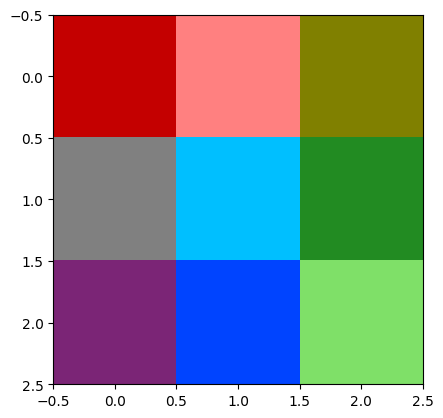

In [11]:
import matplotlib.pyplot as plt

plt.imshow(converted_image)

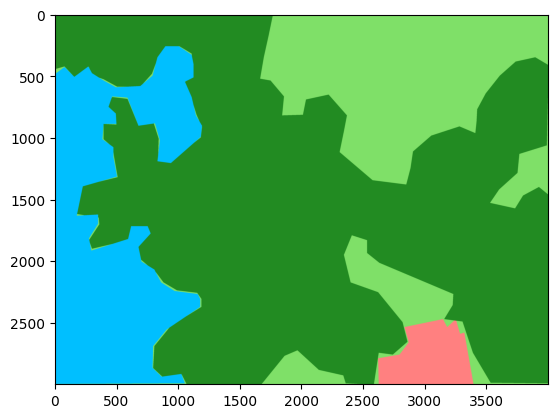

In [22]:
img = convert_image(image, color_mapping)
plt.imshow(img)

In [41]:
from tqdm import tqdm
import os

dataset_dir = 'E:\Segmentation\datasets\FloodNet-MetaFormer'

for folder in os.listdir(dataset_dir):
    for file in tqdm(os.listdir(f'{dataset_dir}\{folder}\{folder}-label-img')):
        img = cv2.imread(f'{dataset_dir}\{folder}\{folder}-label-img\{file}', cv2.IMREAD_GRAYSCALE)
        img = convert_image(img, color_mapping)
        cv2.imwrite(f'{dataset_dir}\{folder}\{folder}-label-img\{file}', img)

100%|██████████| 450/450 [04:13<00:00,  1.77it/s]


#### Training

In [42]:
import torch
import transformers
import evaluate

torch.__version__, transformers.__version__, evaluate.__version__

('1.13.1+cu116', '4.38.2', '0.4.1')

In [1]:
!python train.py --batch 16 --imgsz 320 320 --lr 0.0001 --epochs 5

Namespace(epochs=5, lr=0.0001, batch=16, imgsz=[320, 320], scheduler=False, scheduler_epochs=[50])
Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
               

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([11]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

  0%|                    | 0/91 [01:53<?, ?it/s]
Traceback (most recent call last):
  File "e:\Post-Flood-Disaster-Management\Segmentation\Segmentation-2\Mask2Former\train.py", line 117, in <module>
    train_epoch_loss, train_epoch_miou = train(
  File "e:\Post-Flood-Disaster-Management\Segmentation\Segmentat